# EFIT Convergence Analysis (High Current Shots ≥80kA)

이 노트북은 EFIT 데이터 마이닝 결과를 바탕으로 **kfile 전류가 80kA 이상인 고전류 샷들**에 대해 다음을 분석합니다:
1. 각 샷별 kfile 대비 gfile의 수렴률
2. 각 샷의 가장 높은 전류 시점 (kfile current)
3. 수렴된 가장 높은 전류 시점 (gfile current max)
4. ramp-up 단계의 수렴률
5. ramp-down 단계의 수렴률

**필터링 조건**: kfile_plasma_current ≥ 80,000 A


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [90]:
# Load the mined data
data_file = '/home/user1/h5pyd/vaft/workflow/history_data_mining/efit_history_mining.csv'
df = pd.read_csv(data_file)

print(f"Loaded {len(df)} records from {df['shot_number'].nunique()} shots")
print(f"\nData columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Loaded 39935 records from 4133 shots

Data columns: ['shot_number', 'time_ms', 'kfile_path', 'gfile_path', 'gfile_exists', 'kfile_plasma_current', 'gfile_current', 'current_relative_error_percent', 'phase']

First few rows:


,shot_number,time_ms,kfile_path,gfile_path,gfile_exists,kfile_plasma_current,gfile_current,current_relative_error_percent,phase
0,38000,308.0,/srv/vest.filedb/public/38000/efit/kfile/k0380...,NaN,False,10673.458759,NaN,NaN,unknown
1,38000,309.0,/srv/vest.filedb/public/38000/efit/kfile/k0380...,NaN,False,33484.311518,NaN,NaN,ramp-up
2,38000,310.0,/srv/vest.filedb/public/38000/efit/kfile/k0380...,NaN,False,51976.136005,NaN,NaN,ramp-up
3,38000,311.0,/srv/vest.filedb/public/38000/efit/kfile/k0380...,NaN,False,62676.746855,NaN,NaN,ramp-up
4,38000,312.0,/srv/vest.filedb/public/38000/efit/kfile/k0380...,NaN,False,66186.098160,NaN,NaN,ramp-up


In [91]:
# Check data quality
print("Data Quality Check:")
print(f"Records with kfile current data: {df['kfile_plasma_current'].notna().sum()}")
print(f"Records with gfile current data: {df['gfile_current'].notna().sum()}")
print(f"Records with both kfile and gfile data: {(df['kfile_plasma_current'].notna() & df['gfile_current'].notna()).sum()}")
print(f"Records with gfile_exists=True: {df['gfile_exists'].sum()}")

# Check for gfile with zero current (convergence failure)
gfile_with_zero_current = (df['gfile_exists'] == True) & (df['gfile_current'] == 0)
print(f"Records with gfile but zero current (convergence failure): {gfile_with_zero_current.sum()}")

# Create effective convergence flag (gfile exists AND current > 0)
df['effective_convergence'] = df['gfile_exists'] & (df['gfile_current'] > 0)
print(f"Records with effective convergence: {df['effective_convergence'].sum()}")

# Filter for high current shots (kfile current >= 80kA)
print(f"\nFiltering for high current shots (kfile current >= 80kA):")
print(f"Records before filtering: {len(df)}")
df_high_current = df[df['kfile_plasma_current'] >= 10000].copy()
print(f"Records after filtering: {len(df_high_current)}")
print(f"Shots before filtering: {df['shot_number'].nunique()}")
print(f"Shots after filtering: {df_high_current['shot_number'].nunique()}")

# Update df to use filtered data
df = df_high_current

# Show data types and basic stats
print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe())


Data Quality Check:
Records with kfile current data: 39935
Records with gfile current data: 16543
Records with both kfile and gfile data: 16543
Records with gfile_exists=True: 16976
Records with gfile but zero current (convergence failure): 10319
Records with effective convergence: 6203

Filtering for high current shots (kfile current >= 80kA):
Records before filtering: 39935
Records after filtering: 26767
Shots before filtering: 4133
Shots after filtering: 1937

Data types:
shot_number                         int64
time_ms                           float64
kfile_path                         object
gfile_path                         object
gfile_exists                         bool
kfile_plasma_current              float64
gfile_current                     float64
current_relative_error_percent    float64
phase                              object
effective_convergence                bool
dtype: object

Basic statistics:
        shot_number       time_ms  kfile_plasma_current  gfile_curr

## 1. 샷별 수렴률 분석

각 샷에 대해 kfile 대비 gfile의 수렴률을 계산합니다.


In [92]:
def calculate_shot_convergence_stats(df):
    """Calculate convergence statistics for each shot"""
    shot_stats = []
    
    for shot_num in df['shot_number'].unique():
        shot_data = df[df['shot_number'] == shot_num].copy()
        
        # Basic counts
        total_kfiles = len(shot_data)
        gfile_exists_count = shot_data['gfile_exists'].sum()
        effective_converged_count = shot_data['effective_convergence'].sum()
        
        # Convergence rates
        gfile_existence_rate = (gfile_exists_count / total_kfiles * 100) if total_kfiles > 0 else 0
        effective_convergence_rate = (effective_converged_count / total_kfiles * 100) if total_kfiles > 0 else 0
        
        # Current analysis
        kfile_currents = shot_data['kfile_plasma_current'].dropna()
        gfile_currents = shot_data[shot_data['gfile_current'] > 0]['gfile_current']  # Only non-zero currents
        
        max_kfile_current = kfile_currents.max() if len(kfile_currents) > 0 else None
        max_gfile_current = gfile_currents.max() if len(gfile_currents) > 0 else None
        
        # Error analysis for effectively converged cases (gfile exists AND current > 0)
        effective_converged_data = shot_data[shot_data['effective_convergence'] & 
                                           shot_data['kfile_plasma_current'].notna() & 
                                           shot_data['gfile_current'].notna()]
        
        avg_error = effective_converged_data['current_relative_error_percent'].mean() if len(effective_converged_data) > 0 else None
        max_error = effective_converged_data['current_relative_error_percent'].max() if len(effective_converged_data) > 0 else None
        
        # Count convergence failures (gfile exists but current = 0)
        convergence_failures = shot_data['gfile_exists'].sum() - shot_data['effective_convergence'].sum()
        
        shot_stats.append({
            'shot_number': shot_num,
            'total_kfiles': total_kfiles,
            'gfile_exists_count': gfile_exists_count,
            'effective_converged_count': effective_converged_count,
            'convergence_failures': convergence_failures,
            'gfile_existence_rate_percent': gfile_existence_rate,
            'effective_convergence_rate_percent': effective_convergence_rate,
            'max_kfile_current': max_kfile_current,
            'max_gfile_current': max_gfile_current,
            'avg_current_error_percent': avg_error,
            'max_current_error_percent': max_error,
            'effective_converged_points': len(effective_converged_data)
        })
    
    return pd.DataFrame(shot_stats)

# Calculate shot statistics
shot_stats = calculate_shot_convergence_stats(df)
print("Shot-level Convergence Statistics:")
print(shot_stats)


Shot-level Convergence Statistics:
      shot_number  total_kfiles  gfile_exists_count  \
0           38000            17                   7   
1           38027             7                   0   
2           38028            10                   1   
3           38029             9                   2   
4           38030             9                   2   
...           ...           ...                 ...   
1932        46356             9                   0   
1933        46357             9                   0   
1934        46358            10                   0   
1935        46359             9                   0   
1936        46360             9                   0   

      effective_converged_count  convergence_failures  \
0                             7                     0   
1                             0                     0   
2                             1                     0   
3                             2                     0   
4                  

## 2. 수렴률 시각화


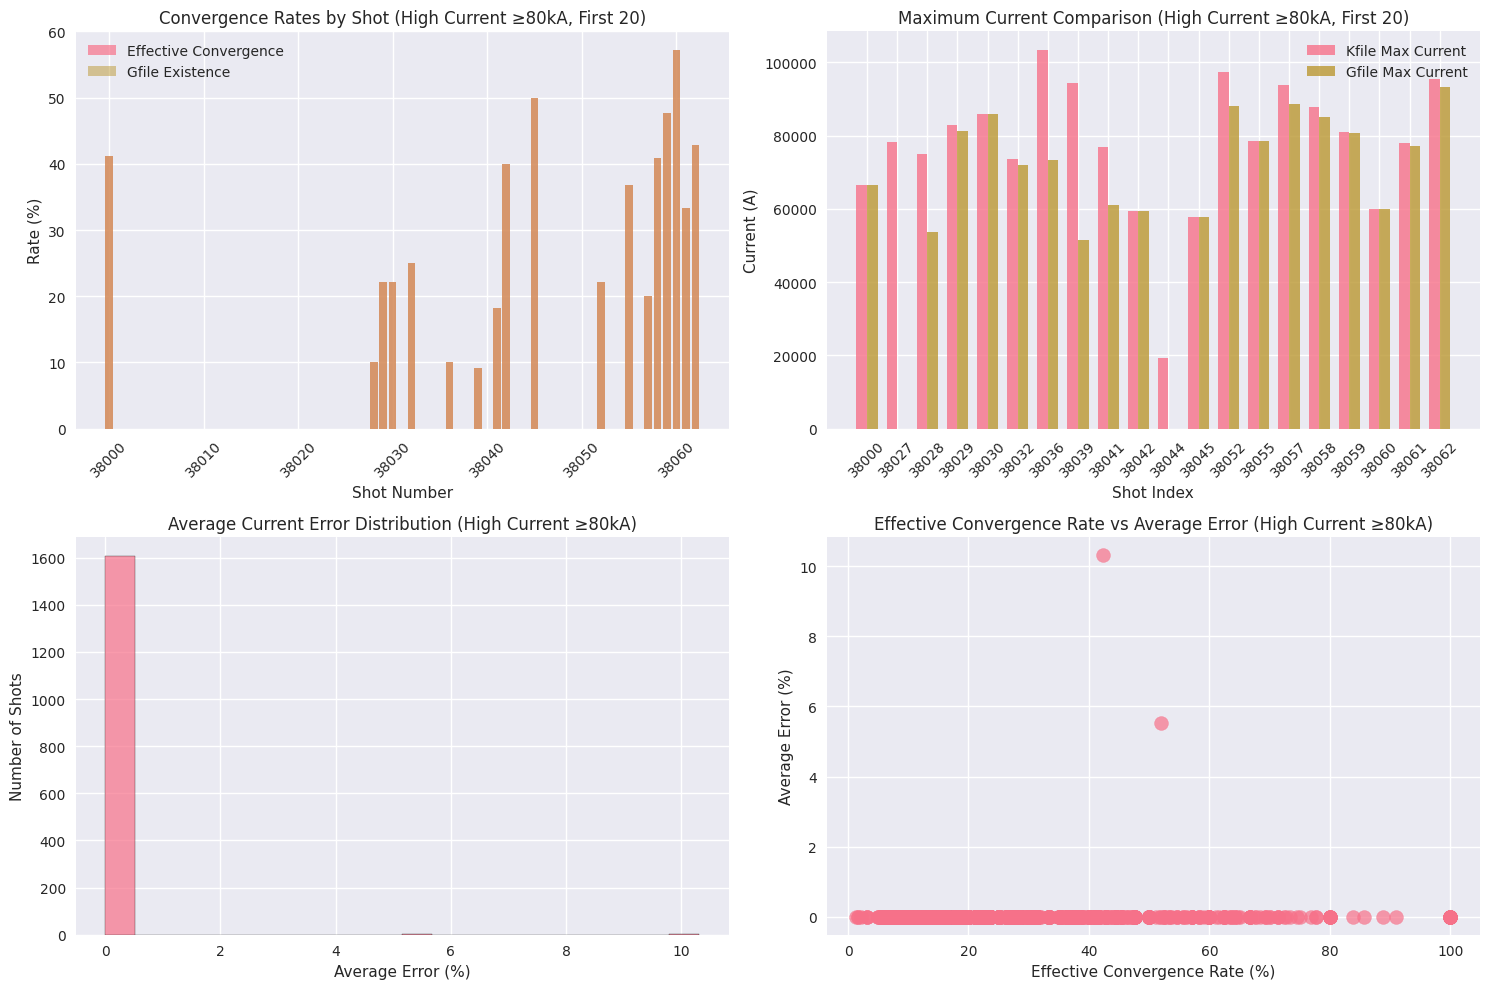

In [93]:
# Plot convergence rates
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Effective convergence rate by shot (first 20 shots for visibility)
sample_shots = shot_stats.head(20)
axes[0, 0].bar(sample_shots['shot_number'], sample_shots['effective_convergence_rate_percent'], 
               alpha=0.7, label='Effective Convergence')
axes[0, 0].bar(sample_shots['shot_number'], sample_shots['gfile_existence_rate_percent'], 
               alpha=0.5, label='Gfile Existence')
axes[0, 0].set_title('Convergence Rates by Shot (High Current ≥80kA, First 20)')
axes[0, 0].set_xlabel('Shot Number')
axes[0, 0].set_ylabel('Rate (%)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend()

# 2. Max current comparison (first 20 shots)
x = np.arange(len(sample_shots))
width = 0.35
axes[0, 1].bar(x - width/2, sample_shots['max_kfile_current'], width, label='Kfile Max Current', alpha=0.8)
axes[0, 1].bar(x + width/2, sample_shots['max_gfile_current'], width, label='Gfile Max Current', alpha=0.8)
axes[0, 1].set_title('Maximum Current Comparison (High Current ≥80kA, First 20)')
axes[0, 1].set_xlabel('Shot Index')
axes[0, 1].set_ylabel('Current (A)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(sample_shots['shot_number'], rotation=45)
axes[0, 1].legend()

# 3. Current error distribution
error_data = shot_stats['avg_current_error_percent'].dropna()
if len(error_data) > 0:
    axes[1, 0].hist(error_data, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Average Current Error Distribution (High Current ≥80kA)')
    axes[1, 0].set_xlabel('Average Error (%)')
    axes[1, 0].set_ylabel('Number of Shots')
else:
    axes[1, 0].text(0.5, 0.5, 'No error data available', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Average Current Error Distribution (High Current ≥80kA)')

# 4. Convergence vs Error scatter
effective_converged_shots = shot_stats[shot_stats['effective_converged_points'] > 0]
if len(effective_converged_shots) > 0:
    scatter = axes[1, 1].scatter(effective_converged_shots['effective_convergence_rate_percent'], 
                               effective_converged_shots['avg_current_error_percent'],
                               s=100, alpha=0.7)
    axes[1, 1].set_title('Effective Convergence Rate vs Average Error (High Current ≥80kA)')
    axes[1, 1].set_xlabel('Effective Convergence Rate (%)')
    axes[1, 1].set_ylabel('Average Error (%)')
else:
    axes[1, 1].text(0.5, 0.5, 'No converged data available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Effective Convergence Rate vs Average Error (High Current ≥80kA)')

plt.tight_layout()
plt.show()


## 3. Ramp-up/Ramp-down 단계별 분석

각 샷의 시간 순서에 따라 ramp-up과 ramp-down 단계를 구분하고, 각 단계별 수렴률을 분석합니다.


In [94]:
def analyze_ramp_phases(df):
    """Analyze convergence rates for ramp-up and ramp-down phases"""
    phase_stats = []
    
    for shot_num in df['shot_number'].unique():
        shot_data = df[df['shot_number'] == shot_num].copy()
        
        # Sort by time
        shot_data = shot_data.sort_values('time_ms')
        
        # Determine phases based on current changes
        phases = []
        currents = shot_data['kfile_plasma_current'].values
        
        for i in range(len(currents)):
            if i == 0 or pd.isna(currents[i]) or pd.isna(currents[i-1]):
                phases.append('unknown')
            elif currents[i] > currents[i-1]:
                phases.append('ramp-up')
            elif currents[i] < currents[i-1]:
                phases.append('ramp-down')
            else:
                phases.append('flat')
        
        shot_data['phase'] = phases
        
        # Count flat points (considered error conditions)
        flat_points = shot_data[shot_data['phase'] == 'flat']
        if len(flat_points) > 0:
            phase_stats.append({
                'shot_number': shot_num,
                'phase': 'flat_error',
                'total_points': len(flat_points),
                'gfile_exists_points': flat_points['gfile_exists'].sum(),
                'effective_converged_points': flat_points['effective_convergence'].sum(),
                'gfile_existence_rate_percent': (flat_points['gfile_exists'].sum() / len(flat_points) * 100) if len(flat_points) > 0 else 0,
                'effective_convergence_rate_percent': (flat_points['effective_convergence'].sum() / len(flat_points) * 100) if len(flat_points) > 0 else 0,
                'avg_error_percent': None
            })
        
        # Analyze each phase (exclude 'flat' as it's considered an error condition)
        for phase in ['ramp-up', 'ramp-down']:
            phase_data = shot_data[shot_data['phase'] == phase]
            
            if len(phase_data) > 0:
                total_points = len(phase_data)
                gfile_exists_points = phase_data['gfile_exists'].sum()
                effective_converged_points = phase_data['effective_convergence'].sum()
                
                gfile_existence_rate = (gfile_exists_points / total_points * 100) if total_points > 0 else 0
                effective_convergence_rate = (effective_converged_points / total_points * 100) if total_points > 0 else 0
                
                # Calculate average error for effectively converged points
                effective_converged_phase_data = phase_data[phase_data['effective_convergence'] & 
                                                          phase_data['kfile_plasma_current'].notna() & 
                                                          phase_data['gfile_current'].notna()]
                
                avg_error = effective_converged_phase_data['current_relative_error_percent'].mean() if len(effective_converged_phase_data) > 0 else None
                
                phase_stats.append({
                    'shot_number': shot_num,
                    'phase': phase,
                    'total_points': total_points,
                    'gfile_exists_points': gfile_exists_points,
                    'effective_converged_points': effective_converged_points,
                    'gfile_existence_rate_percent': gfile_existence_rate,
                    'effective_convergence_rate_percent': effective_convergence_rate,
                    'avg_error_percent': avg_error
                })
    
    return pd.DataFrame(phase_stats)

# Analyze ramp phases
phase_stats = analyze_ramp_phases(df)
print("Phase-level Analysis:")
print(phase_stats)


Phase-level Analysis:
      shot_number      phase  total_points  gfile_exists_points  \
0           38000    ramp-up             5                    1   
1           38000  ramp-down            11                    6   
2           38027    ramp-up             5                    0   
3           38027  ramp-down             1                    0   
4           38028    ramp-up             7                    0   
...           ...        ...           ...                  ...   
3869        46358  ramp-down             5                    0   
3870        46359    ramp-up             4                    0   
3871        46359  ramp-down             4                    0   
3872        46360    ramp-up             5                    0   
3873        46360  ramp-down             3                    0   

      effective_converged_points  gfile_existence_rate_percent  \
0                              1                     20.000000   
1                              6         

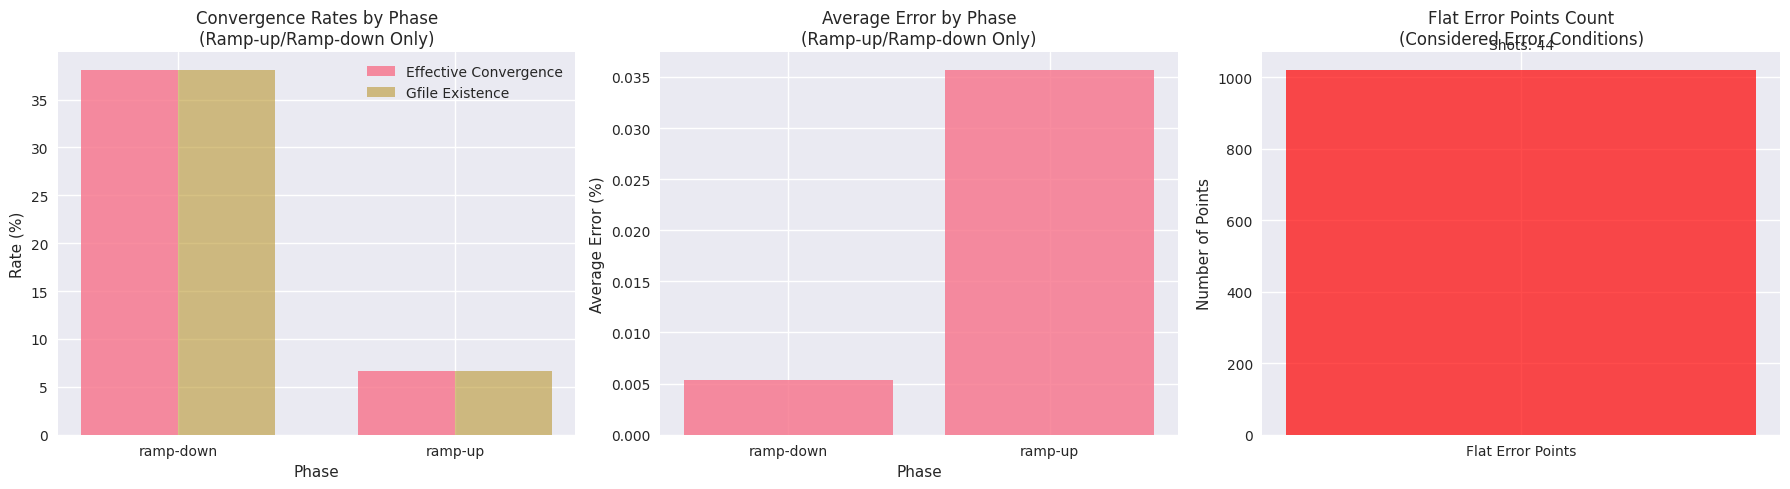

In [95]:
# Visualize phase analysis
if len(phase_stats) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Convergence rates by phase (ramp-up, ramp-down only)
    valid_phases = phase_stats[~phase_stats['phase'].str.contains('flat_error')]
    if len(valid_phases) > 0:
        phase_effective_convergence = valid_phases.groupby('phase')['effective_convergence_rate_percent'].mean()
        phase_gfile_existence = valid_phases.groupby('phase')['gfile_existence_rate_percent'].mean()
        
        x = np.arange(len(phase_effective_convergence))
        width = 0.35
        
        axes[0].bar(x - width/2, phase_effective_convergence.values, width, 
                   label='Effective Convergence', alpha=0.8)
        axes[0].bar(x + width/2, phase_gfile_existence.values, width, 
                   label='Gfile Existence', alpha=0.6)
        axes[0].set_title('Convergence Rates by Phase\n(Ramp-up/Ramp-down Only)')
        axes[0].set_xlabel('Phase')
        axes[0].set_ylabel('Rate (%)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(phase_effective_convergence.index)
        axes[0].legend()
    
    # 2. Error by phase (ramp-up, ramp-down only)
    if len(valid_phases) > 0:
        phase_error = valid_phases.groupby('phase')['avg_error_percent'].mean()
        axes[1].bar(phase_error.index, phase_error.values, alpha=0.8)
        axes[1].set_title('Average Error by Phase\n(Ramp-up/Ramp-down Only)')
        axes[1].set_xlabel('Phase')
        axes[1].set_ylabel('Average Error (%)')
    
    # 3. Flat error points count
    flat_errors = phase_stats[phase_stats['phase'] == 'flat_error']
    if len(flat_errors) > 0:
        total_flat_points = flat_errors['total_points'].sum()
        total_flat_shots = len(flat_errors['shot_number'].unique())
        axes[2].bar(['Flat Error Points'], [total_flat_points], alpha=0.7, color='red')
        axes[2].set_title('Flat Error Points Count\n(Considered Error Conditions)')
        axes[2].set_ylabel('Number of Points')
        axes[2].text(0, total_flat_points + total_flat_points*0.05, 
                    f'Shots: {total_flat_shots}', ha='center', va='bottom')
    else:
        axes[2].text(0.5, 0.5, 'No flat error points', ha='center', va='center', 
                    transform=axes[2].transAxes)
        axes[2].set_title('Flat Error Points Count\n(Considered Error Conditions)')
    
    plt.tight_layout()
    plt.show()
else:
    print("No phase data available for analysis")


## 4. 종합 분석 결과


In [96]:
# Summary statistics
print("=== EFIT Convergence Analysis Summary (High Current Shots ≥80kA) ===")
print(f"\nTotal shots analyzed: {len(shot_stats)}")
print(f"Average gfile existence rate: {shot_stats['gfile_existence_rate_percent'].mean():.1f}%")
print(f"Average effective convergence rate: {shot_stats['effective_convergence_rate_percent'].mean():.1f}%")
print(f"Shots with any gfile existence: {(shot_stats['gfile_exists_count'] > 0).sum()}")
print(f"Shots with effective convergence: {(shot_stats['effective_converged_count'] > 0).sum()}")
print(f"Total convergence failures (gfile exists but current=0): {shot_stats['convergence_failures'].sum()}")
print(f"\nNote: Analysis limited to shots with kfile current ≥ 80,000 A")

if shot_stats['max_kfile_current'].notna().any():
    print(f"\nCurrent Analysis:")
    print(f"Average max kfile current: {shot_stats['max_kfile_current'].mean():.1f} A")
    print(f"Average max gfile current: {shot_stats['max_gfile_current'].mean():.1f} A")

if shot_stats['avg_current_error_percent'].notna().any():
    print(f"\nError Analysis:")
    print(f"Average current error: {shot_stats['avg_current_error_percent'].mean():.2f}%")
    print(f"Maximum current error: {shot_stats['max_current_error_percent'].max():.2f}%")

if len(phase_stats) > 0:
    print(f"\nPhase Analysis:")
    # Valid phases (ramp-up, ramp-down)
    valid_phases = phase_stats[~phase_stats['phase'].str.contains('flat_error')]
    for phase in valid_phases['phase'].unique():
        phase_data = valid_phases[valid_phases['phase'] == phase]
        print(f"{phase}: {phase_data['effective_convergence_rate_percent'].mean():.1f}% effective convergence rate")
    
    # Flat error summary
    flat_errors = phase_stats[phase_stats['phase'] == 'flat_error']
    if len(flat_errors) > 0:
        total_flat_points = flat_errors['total_points'].sum()
        total_flat_shots = len(flat_errors['shot_number'].unique())
        print(f"flat_error: {total_flat_points} points across {total_flat_shots} shots (considered error conditions)")

# Save results
output_dir = Path('/home/user1/h5pyd/vaft/workflow/history_data_mining')
shot_stats.to_csv(output_dir / 'shot_convergence_stats.csv', index=False)
if len(phase_stats) > 0:
    phase_stats.to_csv(output_dir / 'phase_convergence_stats.csv', index=False)

print(f"\nResults saved to:")
print(f"- Shot statistics: {output_dir / 'shot_convergence_stats.csv'}")
if len(phase_stats) > 0:
    print(f"- Phase statistics: {output_dir / 'phase_convergence_stats.csv'}")


=== EFIT Convergence Analysis Summary (High Current Shots ≥80kA) ===

Total shots analyzed: 1937
Average gfile existence rate: 20.4%
Average effective convergence rate: 20.4%
Shots with any gfile existence: 1608
Shots with effective convergence: 1608
Total convergence failures (gfile exists but current=0): 0

Note: Analysis limited to shots with kfile current ≥ 80,000 A

Current Analysis:
Average max kfile current: 109545.2 A
Average max gfile current: 83336.8 A

Error Analysis:
Average current error: 0.01%
Maximum current error: 72.01%

Phase Analysis:
ramp-up: 6.6% effective convergence rate
ramp-down: 38.1% effective convergence rate
flat_error: 1020 points across 44 shots (considered error conditions)

Results saved to:
- Shot statistics: /home/user1/h5pyd/vaft/workflow/history_data_mining/shot_convergence_stats.csv
- Phase statistics: /home/user1/h5pyd/vaft/workflow/history_data_mining/phase_convergence_stats.csv
